In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator

# 1. Read training data

In [4]:
df = pd.read_csv("data/9_clean_training_data/clean_training_data.csv")

<Axes: xlabel='region_id', ylabel='gwl_cm'>

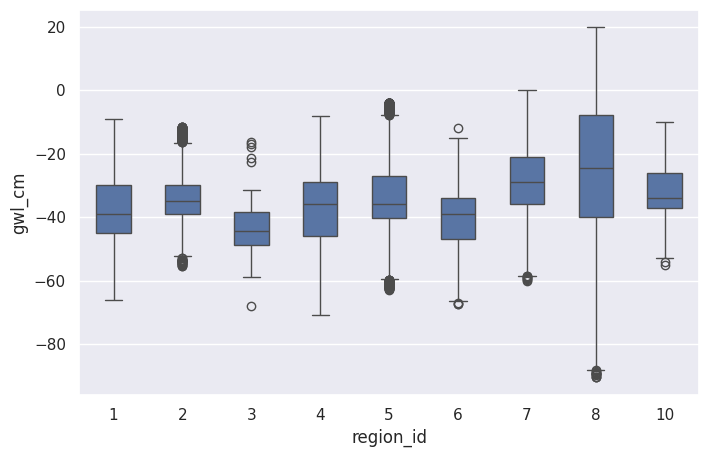

In [5]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

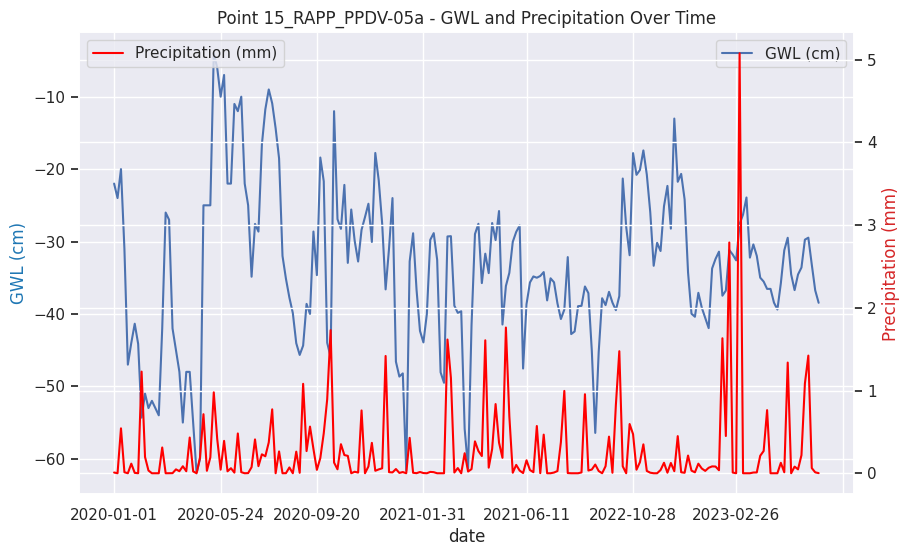

In [6]:
# Filter the DataFrame for the specific point '15_RAPP_PPDV-05a'
point_df = df[df.id == '15_RAPP_PPDV-05a']
point_df = point_df.sort_values(by=['date'])

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=point_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="precipitation", data=point_df, color='red', label="Precipitation (mm)")

# Set the second y-axis label
ax2.set_ylabel("Precipitation (mm)", color='tab:red')

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Set the title and x-axis label
plt.title(f"Point 15_RAPP_PPDV-05a - GWL and Precipitation Over Time")
plt.xlabel("Date")

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()

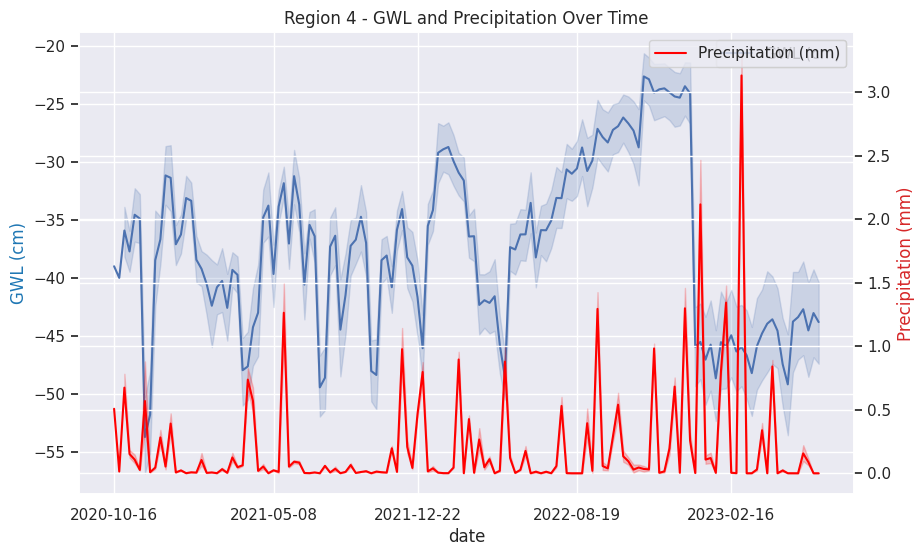

In [7]:
# Filter the DataFrame for the specific region
region_df = df[df.region_id == 4]
region_df = region_df.sort_values(by=['date'])

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=region_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="precipitation", data=region_df, color='red', label="Precipitation (mm)")

# Set the second y-axis label
ax2.set_ylabel("Precipitation (mm)", color='tab:red')

# Set the title and x-axis label
plt.title(f"Region {4} - GWL and Precipitation Over Time")
plt.xlabel("Date")

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

## GWL timeseries in points for PHU 781

In [8]:
import pandas as pd
import geopandas as gpd

In [9]:
# read phu regions shapefile

phu_regions = gpd.read_file("data/0_shp/AOI__Province__865_PHUs__INDONESIA.gpkg")

In [10]:
df = pd.read_csv("data/9_clean_training_data/clean_training_data.csv")

# Convert to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
# Set CRS to WGS84
df.crs = "EPSG:4326"

# add phu region to each point
df = gpd.sjoin(df, phu_regions, how="left", predicate="within")

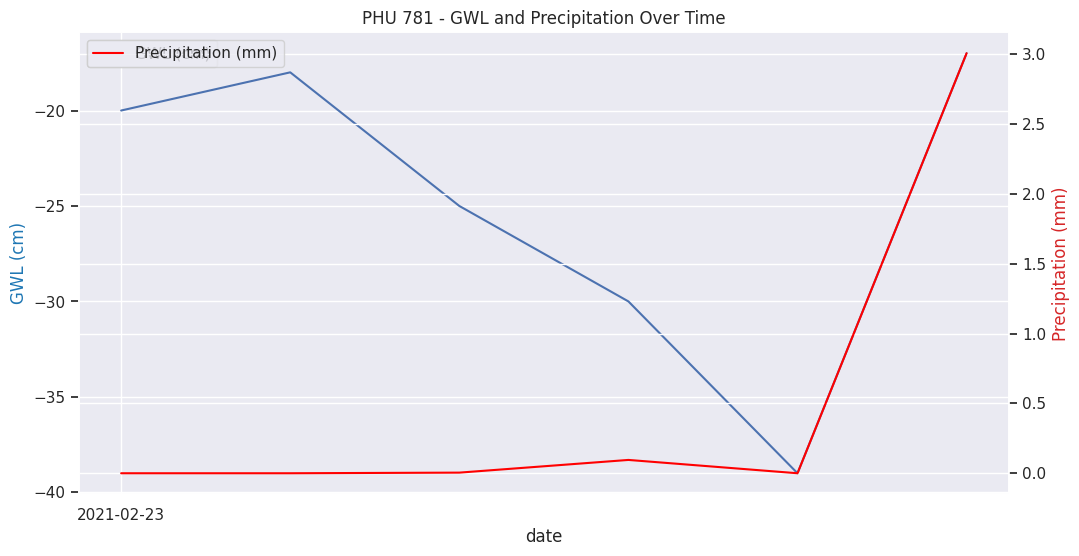

In [11]:
# Filter the DataFrame for the specific region

phu_id = 781

region_df = df[df.id == "15_RAPP_LGBI-018a"]
region_df = region_df.sort_values(by=['date'])

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=region_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="precipitation", data=region_df, color='red', label="Precipitation (mm)")

# Set the second y-axis label
ax2.set_ylabel("Precipitation (mm)", color='tab:red')

# Set the title and x-axis label
plt.title(f"PHU {phu_id} - GWL and Precipitation Over Time")
plt.xlabel("Date")

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

# Create a correlation matrix between dependent and independent variables

In [13]:
df = pd.read_csv("data/9_clean_training_data/clean_training_data.csv")

print("len before: ", len(df))
print("number of stations before: ", len(df.id.unique()))
# count values by id and remove those with less than 9 values

df = df.groupby('id').filter(lambda x : len(x)>8)
print("len after: ", len(df))
print("number of stations after: ", len(df.id.unique()))

len before:  29768
number of stations before:  2023
len after:  23717
number of stations after:  785


In [14]:
explanatory = [
    "doy",
    'VV', 'VH', 'VVVH_ratio', 
    'precipitation', 'prec_3', 'prec_7', 'prec_30', 
    'sm_1',  'sm_3', 'sm_7', 'sm_30'
]

In [15]:
variable = 'gwl_cm'

training_df = df.copy()
row = {}

# All but one PHU for training
for i, station_id in enumerate(training_df.id.unique()):
    explans = []
    
    station_df = training_df[training_df.id == station_id]

    # add correlation of explanatories
    for expl in explanatory:
        explans.append(abs(station_df[variable].corr(station_df[expl])))

    row[station_id] = explans

stats_df = pd.DataFrame.from_dict(row, orient='index')

In [16]:
stats_df.columns = explanatory

# Create the mean correlation column and sort
stats_df.loc[:, 'mean_'] = stats_df.mean(axis=1)
stats_df = stats_df.sort_values(by=['mean_'], ascending=False)


In [17]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<Axes: >

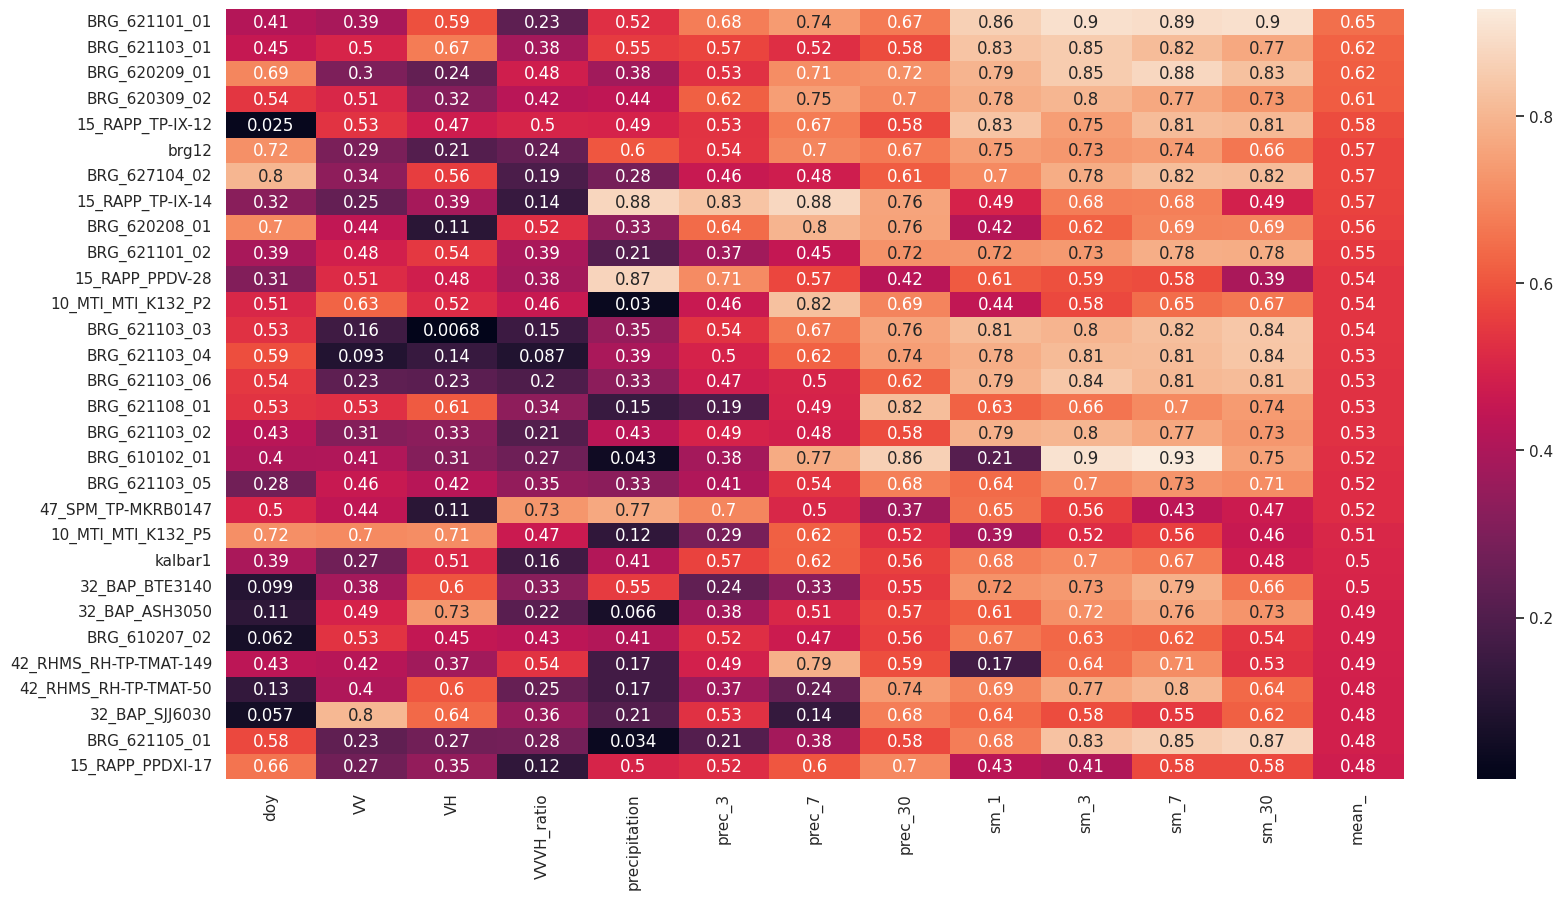

In [18]:
sns.heatmap(stats_df.head(30), annot=True)

<Axes: xlabel='mean_'>

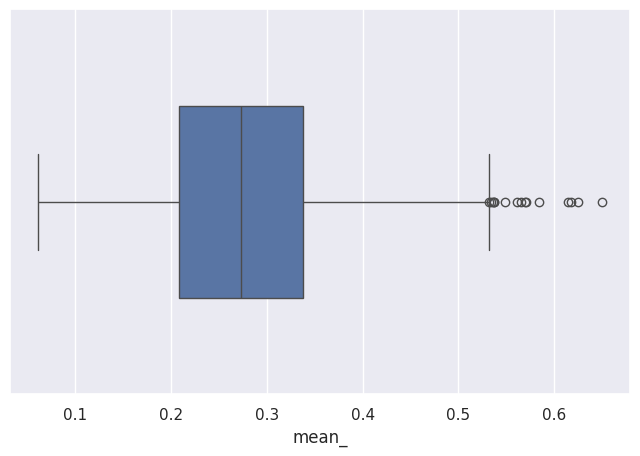

In [20]:
# Create a boxplot of the mean correlation
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="mean_", data=stats_df, width=0.5)


In [31]:
threshold = 0.25
high_corr = pd.DataFrame(stats_df[stats_df.mean_ >= threshold].index.unique())
name = f"high_corr_{threshold}_temporal_variables_station_ids.csv"
len(high_corr), name

(459, 'high_corr_0.25_temporal_variables_station_ids.csv')

In [27]:
high_corr.to_csv(f"data/{name}", index=False)

In [25]:
# open unieqe points geopackage file
unique_points = gpd.read_file("data/0_shp/unique_stations_no_repeated.shp")

# merge the stats_df with the unique_points
unique_points = unique_points.merge(stats_df, left_on='id', right_index=True)

# save the unique_points as a geopackage file
unique_points.to_file("data/0_shp/unique_stations_no_repeated_corr_2.gpkg", driver='GPKG')